# Deep Convolutional Generative Adversarial Network - Classification (2of2)

**Notes about this specific notebook**

Uses grayscale, 64x64 images, with ReLU activation.

Uses 10 and 15 epochs instead of initial 7 and 8. Performance seems worse due to overfitting.

Should use exact same layers as DCGAN model. 

Based on dcgan_v002


# Change

Image height, image width, color channel, ksize and ssize should align with GAN.

Just like the generator and discriminator should be identical to the one in GAN

----------------------------------------------------------------------

In [9]:
# Image size (height x width)
ih = 64
iw = 64

# Grayscale or RGB
ch = 'grayscale'

# Batch size 
batch_size = 40000

# Layer adapt
ksize = 4 # Kernel size : was '4' for 64x64 image
ssize = 2 # Stride size : was '2' for 64x64 image

# Size of test set (in %)
testsize = 0.3

# Number of epochs in untrainable model
epoch_unt = 10

# Number of epochs in trainable model
epoch_t = 15

# Where computation is performed: Kaggle (0) or Local (1)
cenv = 1

-----

In [10]:
if cenv == 0:
    print("Computation environment: Kaggle")
if cenv == 1:
    print("Computation environment: Local")

Computation environment: Local


**Import required packages**

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [12]:
import glob
import os
import PIL
import time
from IPython import display

Automatic parameter changes

In [13]:
im_si = (ih, iw)

if(ch == 'rgb'):
    chnum = 3
elif(ch == 'grayscale'):
    chnum = 1

Create new directory for saving output files

In [14]:
if cenv == 1:
    file_exists = []
    vnum = 1
    dir = "C:/Users/Max/Documents/GitHub/dcgan_classification"
    for files in os.listdir(dir):
        if "dcgan-classification" in files: 
            try:
                vnum = max(vnum, int(files[-3:]))
            except: 
                continue
            new_vnum = vnum + 1
            file_exists.append(True)
        else: 
            file_exists.append(False)
    # If this is the first notebook you want to save, a new folder will be created with version #001
    if sum(file_exists) == 0:
        new_vnum = 1
        print("No matches found")

    else: 
        print(f"{sum(file_exists)} matches(es) found")
        print("--------------")

    # Print new folder name
    print(f"New folder name: dcgan-classification-local-v{new_vnum:03}")
    print("--------------")
    
    # Create new folder with the name of the notebook and the version number
    new_dir = f"/Users/Max/Documents/GitHub/dcgan_classification/dcgan-classification-local-v{new_vnum:03}"
    os.makedirs(new_dir)

3 matches(es) found
--------------
New folder name: dcgan-classification-local-v004
--------------


# Data

In [15]:
if cenv == 0:
    path_root = "/kaggle/input/thesis-data"
    
    # Directory where checkpoints of DCGAN are stored
    checkpoint_dir = "/kaggle/input/checkpoints" 

if cenv == 1:
    path_root = "C:/Users/Max/Documents/thesis_data"
    
    # Directory where checkpoints of DCGAN are stored
    checkpoint_dir = 'C:/Users/Max/Documents/GitHub/dcgan_kaggle_output/dcgan-kaggle-v002/checkpoints'
    

In [16]:
batches = ImageDataGenerator().flow_from_directory(
    directory  = path_root, 
    color_mode = ch, 
    target_size= (ih,iw), 
    class_mode= "sparse", 
    interpolation="bicubic", 
    batch_size=batch_size
)
imgs, labels = next(batches)

Found 26548 images belonging to 11 classes.


In [17]:
imgs.shape

(26548, 64, 64, 1)

In [18]:
batches.class_indices

{'BetterSurf': 0,
 'Eksor.A': 1,
 'Obfuscator.AFQ': 2,
 'Occamy.C': 3,
 'OnLineGames.CTB': 4,
 'Reveton.A': 5,
 'Sfone': 6,
 'VB.IL': 7,
 'Zbot': 8,
 'Zbot!CI': 9,
 'benign': 10}

In [19]:
num_classes = len(batches.class_indices)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=testsize)

In [21]:
classes = batches.class_indices.keys()

In [22]:
multi_distribution = np.unique(labels, return_counts=True)

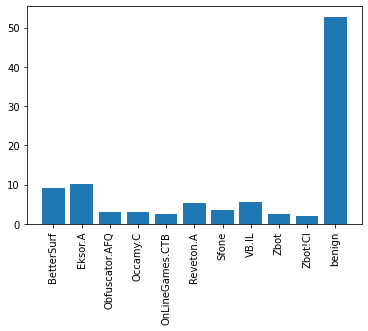

In [23]:
perc = (multi_distribution[1]/labels.shape[0])*100
plt.xticks(rotation='vertical')
plt.bar(classes,perc)
if cenv == 0:
    plt.savefig("multi_data_dist.png", bbox_inches = 'tight')
if cenv == 1:
    plt.savefig(f"{new_dir}/multi_data_dist.png", bbox_inches = 'tight')

In [24]:
trainsize = len(X_train)
testsize = len(X_test)

print(f"Size of training data: {trainsize} | Shape of training data {X_train.shape}")
print(f"Size of training data: {testsize}  | Shape of training data {X_test.shape}")
print(f"Shape of training labels {y_train.shape}")
print(f"Shape of training labels {y_test.shape}")

Size of training data: 18583 | Shape of training data (18583, 64, 64, 1)
Size of training data: 7965  | Shape of training data (7965, 64, 64, 1)
Shape of training labels (18583,)
Shape of training labels (7965,)


In [25]:
def my_fmt(x):
    return '{:.1f}%\n({:.0f})'.format(x, total*x/100)
total = trainsize + testsize

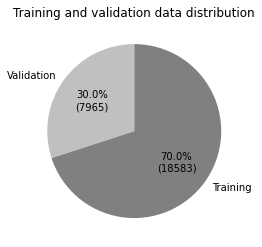

In [26]:
plt.pie(
    [trainsize, testsize], 
    labels = ["Training", "Validation"], 
    startangle=90, 
    counterclock=False, 
    autopct=my_fmt,
    colors = ['gray', 'silver']
)

plt.title("Training and validation data distribution")

if cenv == 0:
    plt.savefig("train_test_dist.png", bbox_inches = 'tight')
if cenv == 1:
    plt.savefig(f"{new_dir}/train_test_dist.png", bbox_inches = 'tight')

# Preparing models

In [27]:
latent_dim = ih
sih = ih//8
siw = iw//8

generator = keras.Sequential(
    [
          keras.layers.InputLayer(input_shape=(latent_dim)),
          
          layers.Dense(sih * siw * latent_dim),
          layers.Reshape((sih, siw, latent_dim)),
          layers.Conv2DTranspose(latent_dim, kernel_size=ksize, strides=ssize, padding="same"),
          layers.ReLU(),
          layers.Conv2DTranspose(2*latent_dim, kernel_size=ksize, strides=ssize, padding="same"),
          layers.ReLU(),
          layers.Conv2DTranspose(4*latent_dim, kernel_size=ksize, strides=ssize, padding="same"),
          layers.ReLU(),
          layers.Conv2D(chnum, kernel_size=ksize+1, padding="same", activation="sigmoid"),
      ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              266240    
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 64)        65600     
_________________________________________________________________
re_lu (ReLU)                 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 128)       131200    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 256)       52

In [28]:
discriminator = keras.Sequential(
       [
        
          layers.Conv2D(ih, kernel_size=ksize, strides=ssize, padding="same",
                        input_shape=(ih, iw, chnum)),
          layers.ReLU(),
          layers.Conv2D(2*ih, kernel_size=ksize, strides=ssize, padding="same"),
          layers.ReLU(),
          layers.Conv2D(2*ih, kernel_size=ksize, strides=ssize, padding="same"),
          layers.ReLU(),
          layers.Flatten(),
          layers.Dropout(0.2),
          layers.Dense(1, activation="sigmoid"),
      ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1088      
_________________________________________________________________
re_lu_3 (ReLU)               (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
re_lu_4 (ReLU)               (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
re_lu_5 (ReLU)               (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)            

In [29]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [30]:

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [31]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Now, we transfer the weights of discriminator except the last layer to a new model, add a dense layer with 128 units, and add another dense layer with 10 units and softmax activation.

In [32]:
disc = checkpoint.discriminator
    
classification_model = Sequential()
for i in range(len(disc.layers) - 1):
    classification_model.add(disc.layers[i])

for layer in classification_model.layers:
    layers.trainable = False

classification_model.add(Dense(128, activation = "relu"))
classification_model.add(Dense(num_classes, activation = "softmax"))
classification_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1088      
_________________________________________________________________
re_lu_3 (ReLU)               (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
re_lu_4 (ReLU)               (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
re_lu_5 (ReLU)               (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0

In [33]:
# view the initialized weights and bias of the second last dense layer; weights are uniformly randomly generated 
# and biases are all zeroes by default
classification_model.layers[-2].weights

[<tf.Variable 'dense_2/kernel:0' shape=(8192, 128) dtype=float32, numpy=
 array([[ 0.01104169,  0.02394717,  0.02490761, ..., -0.0115247 ,
         -0.0150388 ,  0.00723797],
        [ 0.01530039,  0.01205354,  0.02202372, ...,  0.0077039 ,
         -0.01334127, -0.02448027],
        [-0.02391124,  0.0167334 , -0.00630949, ..., -0.01188552,
          0.00243295,  0.02532762],
        ...,
        [ 0.01974608, -0.01385825, -0.00078632, ...,  0.01647556,
          0.01849804, -0.0116056 ],
        [ 0.02059745, -0.00511105, -0.00053008, ..., -0.01701061,
          0.01375216, -0.02437558],
        [-0.01442332, -0.02218303, -0.01475619, ...,  0.00261878,
         -0.02602176, -0.00699888]], dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(128,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [34]:
train_images = X_train.reshape((trainsize, ih,iw,chnum))
train_images = train_images.astype('float32') / 255 # Was *255
train_images.shape

(18583, 64, 64, 1)

In [35]:
test_images = X_test.reshape((testsize, ih,iw,chnum))
test_images = test_images.astype('float32') / 255 # Was *255

In [36]:
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(18583, 64, 64, 1) (18583, 11) (7965, 64, 64, 1) (7965, 11)


In [37]:
classification_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history1 = classification_model.fit(train_images, train_labels, batch_size=100, epochs=epoch_unt,
                        validation_data=(test_images, test_labels))

Epoch 1/10
186/186 [==============================] - 6s 19ms/step - loss: 0.4788 - accuracy: 0.8644 - val_loss: 0.2812 - val_accuracy: 0.9149
Epoch 2/10
186/186 [==============================] - 3s 16ms/step - loss: 0.2230 - accuracy: 0.9312 - val_loss: 0.2403 - val_accuracy: 0.9313
Epoch 3/10
186/186 [==============================] - 3s 17ms/step - loss: 0.1695 - accuracy: 0.9446 - val_loss: 0.2144 - val_accuracy: 0.9372
Epoch 4/10
186/186 [==============================] - 3s 17ms/step - loss: 0.1377 - accuracy: 0.9553 - val_loss: 0.1910 - val_accuracy: 0.9445
Epoch 5/10
186/186 [==============================] - 3s 16ms/step - loss: 0.1173 - accuracy: 0.9623 - val_loss: 0.1900 - val_accuracy: 0.9450
Epoch 6/10
186/186 [==============================] - 3s 17ms/step - loss: 0.0935 - accuracy: 0.9719 - val_loss: 0.1954 - val_accuracy: 0.9504
Epoch 7/10
186/186 [==============================] - 3s 17ms/step - loss: 0.0831 - accuracy: 0.9736 - val_loss: 0.1935 - val_accuracy: 0.9503

In [38]:
# unfreeze all layers 
for layer in classification_model.layers:
    layer.trainable = True

#optimizer=classification_model.optimizer
#optimizer.learning_rate=0.005
    
classification_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history2 = classification_model.fit(train_images, train_labels, batch_size=100, epochs=epoch_t,
                        validation_data=(test_images, test_labels)) 


Epoch 1/15
186/186 [==============================] - 4s 19ms/step - loss: 0.0626 - accuracy: 0.9799 - val_loss: 0.2340 - val_accuracy: 0.9527
Epoch 2/15
186/186 [==============================] - 3s 17ms/step - loss: 0.0551 - accuracy: 0.9826 - val_loss: 0.2459 - val_accuracy: 0.9514
Epoch 3/15
186/186 [==============================] - 3s 17ms/step - loss: 0.0588 - accuracy: 0.9818 - val_loss: 0.2424 - val_accuracy: 0.9520
Epoch 4/15
186/186 [==============================] - 3s 19ms/step - loss: 0.0472 - accuracy: 0.9851 - val_loss: 0.2701 - val_accuracy: 0.9532
Epoch 5/15
186/186 [==============================] - 3s 17ms/step - loss: 0.0468 - accuracy: 0.9846 - val_loss: 0.2802 - val_accuracy: 0.9535
Epoch 6/15
186/186 [==============================] - 3s 16ms/step - loss: 0.0526 - accuracy: 0.9830 - val_loss: 0.2741 - val_accuracy: 0.9503
Epoch 7/15
186/186 [==============================] - 3s 16ms/step - loss: 0.0538 - accuracy: 0.9822 - val_loss: 0.2792 - val_accuracy: 0.9500

# Evaluating performance

In [39]:
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score
from prettytable import PrettyTable, MSWORD_FRIENDLY

In [40]:
accuracy = history1.history['accuracy'] + history2.history['accuracy']
val_accuracy = history1.history['val_accuracy'] + history2.history['val_accuracy']

loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']

In [41]:
# Calculate total number of epochs (the arrays above are the accuracies for every epoch, so you need the latest one)
total_epochs = epoch_t + epoch_unt

In [42]:
scores = [val_loss, val_accuracy]
print(f"Overall CNN Accuracy: {scores[1][total_epochs-1]}\n(The number of correct predictions divided by the number of total predictions)")
# Total epochs - 1, because array starts at 0

Overall CNN Accuracy: 0.9477714896202087
(The number of correct predictions divided by the number of total predictions)


In [43]:
t = PrettyTable(['Metric', 'Performance'])
t.add_row(['Valididation accuracy', round(scores[1][total_epochs-1],4)])
t.add_row(['Validation loss', round(scores[0][total_epochs-1],4)])
t.header = True
t.align = "l"
t.title = "Performance of multi-class classification - CNN"
print(t)

+-------------------------------------------------+
| Performance of multi-class classification - CNN |
+-------------------------------+-----------------+
| Metric                        | Performance     |
+-------------------------------+-----------------+
| Valididation accuracy         | 0.9478          |
| Validation loss               | 0.3067          |
+-------------------------------+-----------------+


In [44]:
# Saving PrettyTable
table = t.get_string()

if cenv == 0:
    with open('multi_performance_table.txt', 'w') as f:
        f.write(table)
if cenv == 1:
    with open(f'{new_dir}/multi_performance_table.txt', 'w') as f:
        f.write(table)

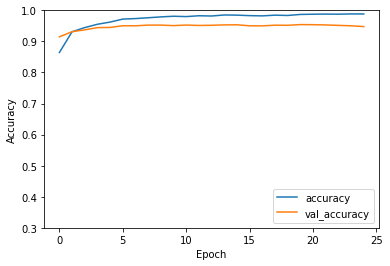

In [45]:
plt.figure()
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')
if cenv == 0:
    plt.savefig("dcgan_class_model_acc.png", bbox_inches = 'tight')
if cenv == 1:
    plt.savefig(f"{new_dir}/dcgan_class_model_acc.png", bbox_inches = 'tight')

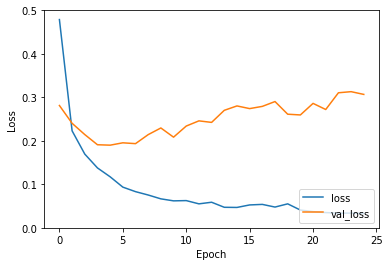

In [46]:
plt.figure()
plt.plot(loss, label='loss')
plt.plot(val_loss, label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 0.5])
plt.legend(loc='lower right')
if cenv == 0:
    plt.savefig("dcgan_class_model_loss.png", bbox_inches = 'tight')
if cenv == 1:
    plt.savefig(f"{new_dir}/dcgan_class_model_loss.png", bbox_inches = 'tight')

We can see that, using the tuned discriminator model, both training accuracy and testing are approximately 0.94 after 15 epochs.

actual label: 10


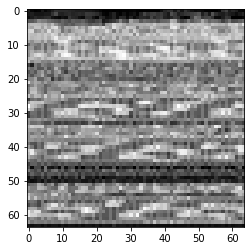

[[8.4575323e-31 8.5783378e-24 3.3527843e-16 1.7972678e-08 9.0274416e-06
  1.8491162e-20 2.3848407e-21 2.7256815e-15 6.0264723e-12 3.5906732e-19
  9.9999094e-01]]
-----------------------------------------------------------------------
prediction: 10


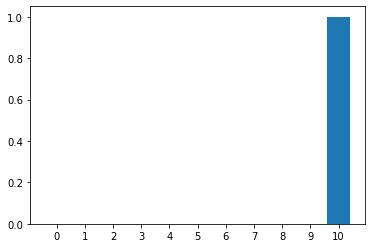

In [47]:
# demonstration: predict the ith test digit
i = np.random.randint(0, testsize)

# show the actual ith digit
print('actual label:', np.argmax(test_labels[i]))
plt.figure()
plt.imshow(test_images[i,:,:,0], cmap='gray')
plt.show()

# predict
prediction = classification_model.predict(test_images[i].reshape(1,ih,iw,chnum))

# get probability distribution and classification of the test digit
print(prediction)
print("-----------------------------------------------------------------------")
print('prediction:', np.argmax(prediction))

# draw the barplot
plt.figure()
plt.bar(np.arange(0,11).astype('str'), prediction[0,:])
plt.show()

# Analyse performance

In [48]:
from sklearn import metrics
import pandas as pd
import seaborn as sns

In [49]:
y_pred = np.argmax(classification_model.predict(test_images), axis=-1)
true_labels = test_labels.argmax(axis=1)

In [50]:
y_pred

array([10, 10, 10, ..., 10, 10,  2], dtype=int64)

In [51]:
y_test2 = np.argmax(test_labels, axis=1)
y_test2

array([10, 10, 10, ..., 10, 10,  2], dtype=int64)

In [52]:
c_matrix = metrics.confusion_matrix(y_test2, y_pred)

In [53]:
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if cenv == 0:
        plt.savefig("multi_class_cmatrix.png")
    if cenv == 1:
        plt.savefig(f"{new_dir}/multi_class_cmatrix.png")

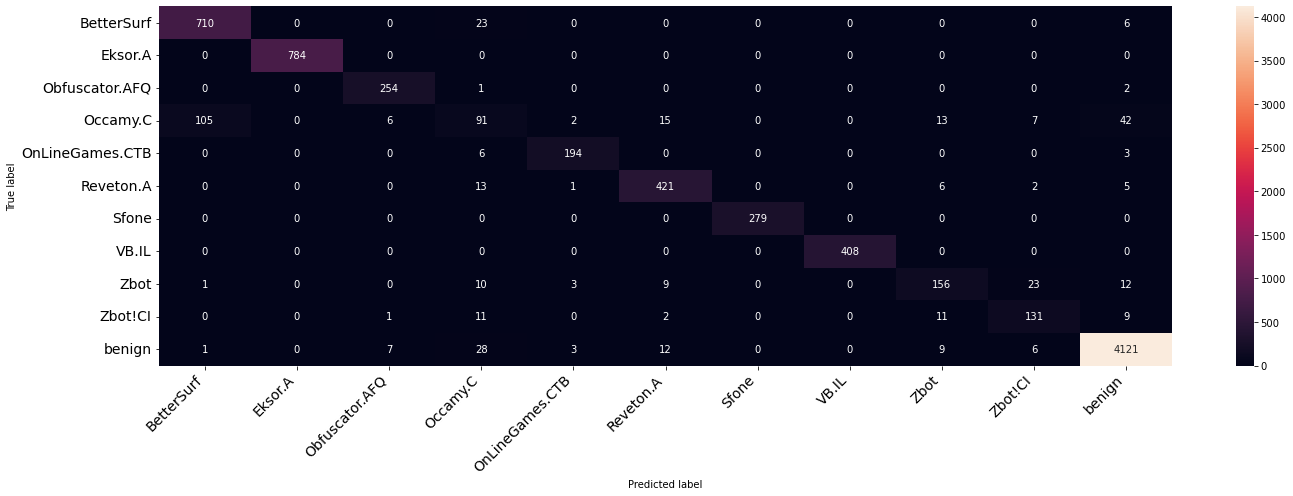

In [54]:
class_names= batches.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)

# Binary classification

In [55]:
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score
from prettytable import PrettyTable, MSWORD_FRIENDLY

In [56]:
y_predbin = [] 
y_truebin = []
for count, value in enumerate(y_test2):
    if y_test2[count] in range(10): # range(10) is 0 to 9
        y_truebin.append(0)
    else: y_truebin.append(1)
    
    if y_pred[count] in range(10):
        y_predbin.append(0)
    else: y_predbin.append(1)
    
    continue
if len(y_truebin) == len(y_predbin):
    print(f"Length of the observations in test set: {len(y_truebin)}")

Length of the observations in test set: 7965


In [57]:
rw_count = 0
bn_count = 0
for count, value in enumerate(multi_distribution[1]):
    if count in range(10):
        rw_count = rw_count + multi_distribution[1][count]
    else: 
        bn_count = bn_count + multi_distribution[1][count]
print(f"Ransomware Occurences: {rw_count}, Benign Occurences: {bn_count}")

Ransomware Occurences: 12536, Benign Occurences: 14012


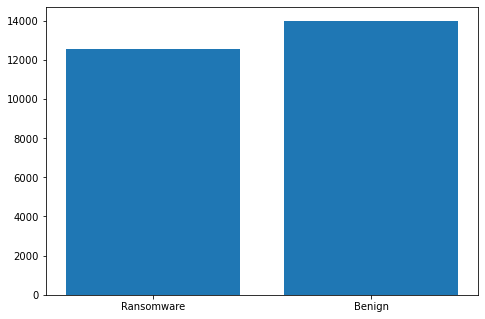

In [58]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x_lab = ['Ransomware', 'Benign']
y_lab = [rw_count, bn_count]
ax.bar(x_lab, y_lab)
if cenv == 0:
    plt.savefig("data_dist.png.png", bbox_inches = 'tight')
if cenv == 1:
    plt.savefig(f"{new_dir}/bin_data_dist.png", bbox_inches = 'tight')

In [59]:
c_matrix_bin = metrics.confusion_matrix(y_truebin, y_predbin)

In [60]:
def confusion_matrix_bin(confusion_matrix, class_names_bin, figsize = (5,2), fontsize=7):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names_bin, columns=class_names_bin, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if cenv == 0:
        plt.savefig("bin_class_cmatrix.png", bbox_inches = 'tight')
    if cenv == 1:
        plt.savefig(f"{new_dir}/bin_class_cmatrix.png", bbox_inches = 'tight')

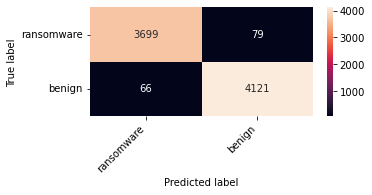

In [61]:
class_names_bin= ("ransomware", "benign")
confusion_matrix_bin(c_matrix_bin, class_names_bin, figsize = (5,2), fontsize=10)

**True Positive Rate**

In [62]:
TPR = c_matrix_bin[0,0]/(c_matrix_bin[0,0] + c_matrix_bin[0,1]) #True Positive Rate

**Accuracy**

In [63]:
ACC = accuracy_score(y_truebin, y_predbin) # Accuracy

**F1 Score**

In [64]:
F1 = f1_score(y_truebin, y_predbin, labels=0) # F1 Score

**Matthews Correlation Coefficient**

In [65]:
MCC = matthews_corrcoef(y_truebin, y_predbin) # Matthews Correlation Coefficient

In [66]:
t = PrettyTable(['Metric', 'Performance'])
t.add_row(['True Positive Rate', round(TPR,4)])
t.add_row(['Accuracy', round(ACC,4)])
t.add_row(['F1 Score', round(F1,4)])
t.add_row(['Matthews Correlation Coefficient', round(MCC,4)])
t.header = True
t.align = "l"
t.title = "Performance of GAN"
print(t)

+------------------------------------------------+
|               Performance of GAN               |
+----------------------------------+-------------+
| Metric                           | Performance |
+----------------------------------+-------------+
| True Positive Rate               | 0.9791      |
| Accuracy                         | 0.9818      |
| F1 Score                         | 0.9827      |
| Matthews Correlation Coefficient | 0.9635      |
+----------------------------------+-------------+


In [67]:
# Saving PrettyTable
table = t.get_string()

if cenv == 0:
    with open('bin_performance_table.txt', 'w') as f:
        f.write(table)
if cenv == 1:
    with open(f'{new_dir}/bin_performance_table.txt', 'w') as f:
        f.write(table)

**Generate new digits and perform classification on them using our model**

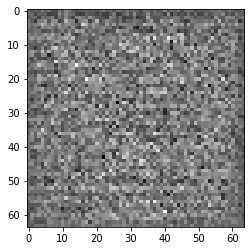

In [68]:
noi = tf.random.normal([1, 64])
sample = checkpoint.generator(noi, training=False)
fig = plt.figure()
plt.imshow(sample[0, :, :, 0], cmap='gray')

[[6.2666871e-02 1.6221720e-10 3.8784733e-06 3.5065964e-01 3.1416625e-04
  6.8857121e-06 2.1992405e-06 3.7651025e-09 1.7129566e-04 1.5858410e-05
  5.8615923e-01]]
prediction: 10


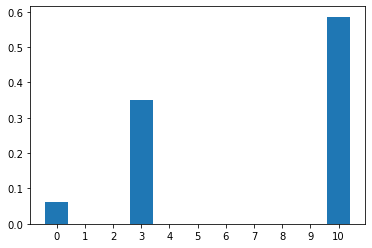

In [69]:
new_sample = sample[0, :, :, 0].numpy().reshape(1,ih,iw,chnum)
new_prediction = classification_model.predict(new_sample)

# get probability distribution and classification of the test digit
print(new_prediction)
print('prediction:', np.argmax(new_prediction))

# draw the barplot
plt.figure()
plt.bar(np.arange(0,11).astype('str'), new_prediction[0,:])
plt.show()

In [70]:
# we can save the numpy array of appropriately generated digits as .npy file,
# which could be used for further training
if cenv == 0:
    np.save('generated_numpy.npy', sample[0, :, :, 0].numpy())
if cenv == 1:
    np.save(f'{new_dir}/generated_numpy.npy', sample[0, :, :, 0].numpy())
